**Anomaly Detection in Temperature Sensor Data using LSTM RNN Model**

In [3]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

The data for this notebook is located here https://www.kaggle.com/boltzmannbrain/nab#. The file is inside the folder realKnownCause/realKnownCause. A copy od this dataset can be downloaded from the repository on github [here](https://raw.githubusercontent.com/orlaede/ml-anomaly-detecttion/main/data/ambient_temperature_system_failure.csv).

In [6]:
!wget https://raw.githubusercontent.com/orlaede/ml-anomaly-detecttion/main/data/ambient_temperature_system_failure.csv

--2022-01-24 15:45:41--  https://raw.githubusercontent.com/orlaede/ml-anomaly-detecttion/main/data/ambient_temperature_system_failure.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233321 (228K) [text/plain]
Saving to: ‘ambient_temperature_system_failure.csv’

ambient_temperature 100%[===================>] 227.85K  --.-KB/s    in 0.03s   

2022-01-24 15:45:41 (8.87 MB/s) - ‘ambient_temperature_system_failure.csv’ saved [233321/233321]



In [7]:
#Reading file from local system
df = pd.read_csv("ambient_temperature_system_failure.csv")

In [ ]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


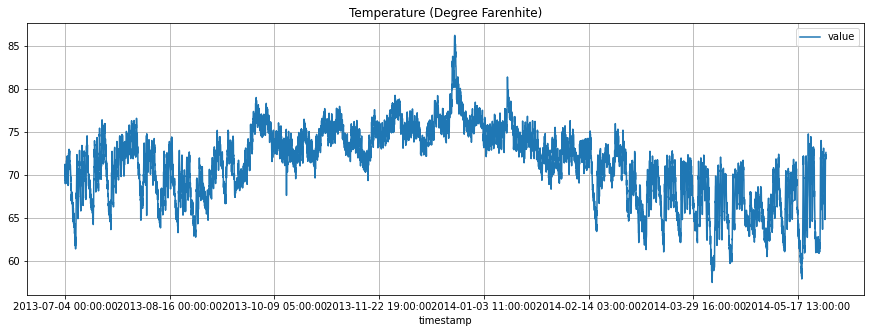

In [8]:
#Visualize the data
figsize=(15,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.grid();
plt.show();

As we can see that the dates do not appear clearly on the X-axis, we need to change the type of timestamp column. As the temperature in our data set is given in the degree Fahrenheit, we will convert it into degree Celcius.

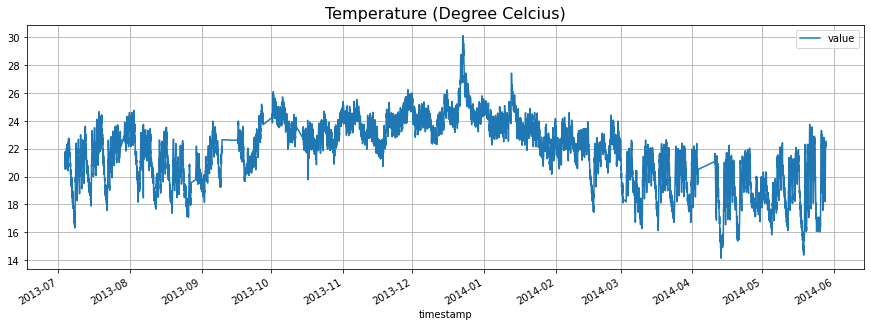

In [9]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

Now we can see the data is visualized perfectly. To check the stability of temperature during days and nights of weekdays and weekends we are going to preprocess our data accordingly. First, we will specify hours, then days, then weekdays and nights. Finally, we will visualize the temperature during these time-periods using a histogram. 

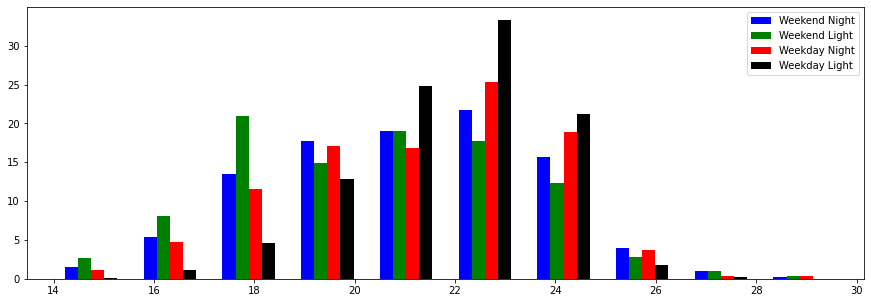

In [11]:
# Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

# Visualizing the formatted data
figsize=(15,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

The above histogram shows that the temperature is comparatively more stable during Week Days in the daylights. Now, we will preprocess our dataset for training the LSTM recurrent neural network. For this purpose, first, we will take the required columns from the dataset and scale it using Standard Scaler. 

In [14]:
# Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [15]:
data_n

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


In the next step, we will define and initialize the required parameters and define the training and the test data set. We are going to learn from 50 previous values and we predict through the LSTM model just the one next value.

In [16]:
# Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut: ][0].values

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6215, 5), (6215,), (1050, 5), (1050,))

As we know that the architecture of a Recurrent Neural Network has a hidden state. The hidden state at time is a function of the hidden state at time t−1 and the input at time t. This hidden state at the time 0 is typically initialized to 0. The fundamental reason why RNNs are unrolled is that all previous inputs and hidden states are used in order to compute the gradients with respect to the final output of the RNN. The below unrolling function will create a sequence of **50 previous data points** for each of the training and test data point.

In [18]:
def unroll(data, sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [19]:
# Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
# y_train an y_test are equivalent for the close value for tempeture
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [20]:
# Check shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


Convert input data into 3-D array combining TIME_STEPS. The shape of the array should be **[samples, TIME_STEPS, features]**, as required for LSTM network.

**Building The Model**

In the next step, we will define and add layers to the LSTM Recurrent Neural Network one-by-one.

In [21]:
#Building the model
model = Sequential()

# model.add(LSTM(5, input_dim=x_train.shape[-1], output_dim=50, return_sequences=True))
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.010987520217895508


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 71,701
Trainable params: 71,701
Non-traina

In [23]:
# fiting the model
history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=3028, 
                    validation_split=0.1,
                    # callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
                    shuffle=False)


Epoch 1/50
2/2 [==============================] - 12s 3s/step - loss: 0.5813 - val_loss: 0.7577
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 0.1971 - val_loss: 0.4263
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 0.1853 - val_loss: 0.2556
Epoch 4/50
2/2 [==============================] - 6s 3s/step - loss: 0.1209 - val_loss: 0.2059
Epoch 5/50
2/2 [==============================] - 6s 3s/step - loss: 0.1061 - val_loss: 0.1883
Epoch 6/50
2/2 [==============================] - 6s 3s/step - loss: 0.0975 - val_loss: 0.1817
Epoch 7/50
2/2 [==============================] - 6s 3s/step - loss: 0.0924 - val_loss: 0.1726
Epoch 8/50
2/2 [==============================] - 6s 3s/step - loss: 0.0885 - val_loss: 0.1653
Epoch 9/50
2/2 [==============================] - 6s 3s/step - loss: 0.0867 - val_loss: 0.1600
Epoch 10/50
2/2 [==============================] - 6s 3s/step - loss: 0.0857 - val_loss: 0.1549
Epoch 11/50
2/2 [==============================]

After the successful training of the model, we will visualize the training performance.

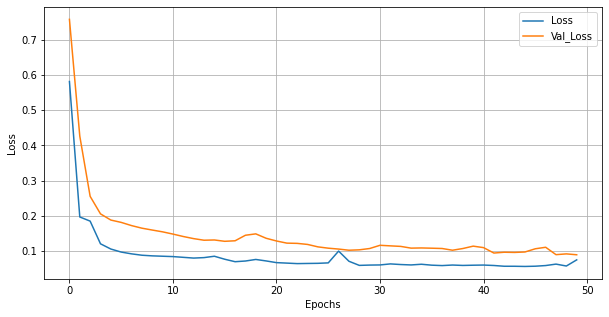

In [24]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [25]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 1s 20ms/step - loss: 0.1385


0.1385263353586197

**Detecting Anomalies**

Now, we will execute the below code snippet to better understand the difference between the original data and the predicted data through the visualization.

In [26]:
# creating the list of differences between prediction and test data
loaded_model = model
diff=[]
ratio=[]
# make predictions
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    # calculate the ratio on test and prediction
    ratio.append((y_test[u]/pr)-1)
    # calculate the difference
    diff.append(abs(y_test[u]- pr))


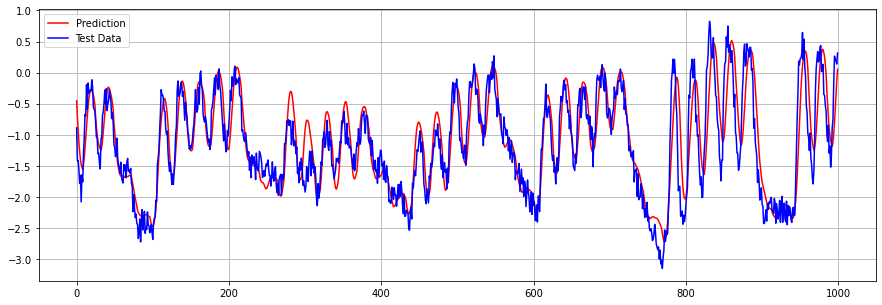

In [28]:
# Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (15, 5))
plt.plot(p, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

Now, in the next step, we are going to find the anomalies. The most distant predicted values are considered as anomalies. For this, we will using the **outlier_fraction** variable to determine the amout of dat point so mark as anomalies. Using the below code snippet, we will find the anomalies in the data.

In [34]:
# Pick the most distant prediction/reality data points as anomalies
# considering thr outlier fraction previously defined
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly'] = complement.append(test, ignore_index='True')
print(df['anomaly'].value_counts())

0    7257
1      10
Name: anomaly, dtype: int64


The feature "anolmaly" means that data point is anomaly ( ==1 ) or not ( ==0 ). So we have 10 data points identified as anomalies.

Finally, we will visualize the anomalies using the below code for plotting.

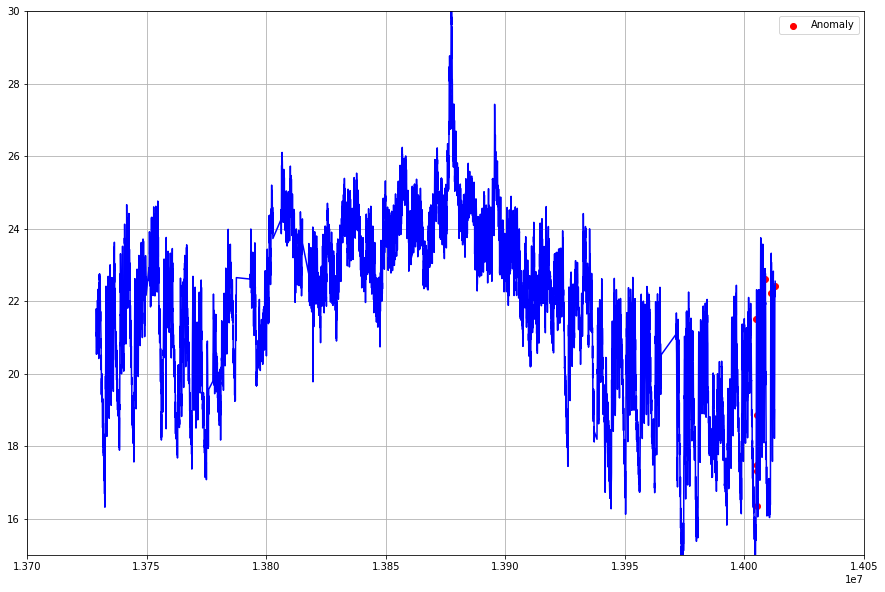

In [35]:
# Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()

As we can see in the above picture, the anomalies are visualized as red points. All the above steps can be repeated multiple times to visualize the anomalies by tuning the hyperparameters. If we find the same visualization at the end, then we can end-up with these anomalies.

In [39]:
# listing anomalies
df.loc[df['anomaly'] == 1]

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,anomaly27,anomaly
7048,2014-05-19 13:00:00,21.506433,13,1,0,1,14005044,3,1,1
7056,2014-05-19 21:00:00,18.857631,21,1,0,1,14005332,3,1,1
7057,2014-05-19 22:00:00,17.314340,22,1,0,1,14005368,3,1,1
7058,2014-05-19 23:00:00,17.486520,23,0,0,1,14005404,2,1,1
7059,2014-05-20 00:00:00,17.482751,0,0,1,1,14005440,2,1,1
7060,2014-05-20 01:00:00,16.349560,1,0,1,1,14005476,2,1,1
7094,2014-05-21 11:00:00,21.920720,11,1,2,1,14006700,3,1,1
7143,2014-05-23 12:00:00,22.614394,12,1,4,1,14008464,3,1,1
7215,2014-05-26 12:00:00,22.237181,12,1,0,1,14011056,3,1,1
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,1,1
